In [5]:
# %pip install anndata

In [6]:
# %pip install matplotlib

In [12]:
# %pip install pyarrow

In [7]:
import numpy as np
import pandas as pd
import tqdm as tq
import anndata as ad
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

In [8]:
import matplotlib.pyplot as plt

# Preprocess data

In [13]:
DATA = "data"

In [14]:
df_train = pd.read_parquet(f"{DATA}/adata_train.parquet", engine="pyarrow")

In [15]:
# df_train["count"] = df_train[["count"]].astype(float)

In [16]:
df_train.head()

,obs_id,gene,count,normalized_count
0,000006a87ba75b72,AATF,1,5.567933
1,000006a87ba75b72,ABHD12,1,5.567933
2,000006a87ba75b72,ABHD3,1,5.567933
3,000006a87ba75b72,AC004687.1,1,5.567933
4,000006a87ba75b72,AC009779.2,1,5.567933


In [17]:
# df_train = df_train.head(1000000)
# df_train_h = df_train

In [22]:
df_train['obs_id'] = df_train['obs_id'].astype('category')
X_train = csr_matrix((df_train["count"].astype(np.float16), (df_train["obs_id"].cat.codes, pd.Categorical(df_train["gene"]).codes)))
# X_train = csr_matrix((df_train["normalized_count"], (df_train["obs_id"].cat.codes, pd.Categorical(df_train["gene"]).codes)))

In [23]:
X_train.shape

(240090, 21255)

In [25]:
ad_train = ad.AnnData(X_train)

In [26]:
ad_train.obs_names = df_train["obs_id"].cat.categories
ad_train.var_names = pd.Categorical(df_train["gene"]).categories

In [27]:
df_train_meta = pd.read_csv(f"{DATA}/adata_obs_meta.csv")

In [28]:
df_train_meta.head()

,obs_id,library_id,plate_name,well,row,col,cell_id,donor_id,cell_type,sm_lincs_id,sm_name,SMILES,dose_uM,timepoint_hr,control
0,000006a87ba75b72,library_4,plate_4,F7,F,7,PBMC,donor_2,T cells CD4+,LSM-4944,MLN 2238,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,1.0,24,False
1,0000233976e3cd37,library_0,plate_3,D4,D,4,PBMC,donor_1,T cells CD4+,LSM-46203,BMS-265246,CCCCOc1c(C(=O)c2c(F)cc(C)cc2F)cnc2[nH]ncc12,1.0,24,False
2,0001533c5e876362,library_2,plate_0,B11,B,11,PBMC,donor_0,T regulatory cells,LSM-45663,Resminostat,CN(C)Cc1ccc(S(=O)(=O)n2ccc(/C=C/C(=O)NO)c2)cc1,1.0,24,False
3,00022f989630d14b,library_35,plate_2,E6,E,6,PBMC,donor_0,T cells CD4+,LSM-43216,FK 866,O=C(/C=C/c1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,1.0,24,False
4,0002560bd38ce03e,library_22,plate_4,B6,B,6,PBMC,donor_2,T cells CD4+,LSM-1099,Nilotinib,Cc1cn(-c2cc(NC(=O)c3ccc(C)c(Nc4nccc(-c5cccnc5)...,1.0,24,False


In [29]:
df_train_meta.shape

(240090, 15)

In [30]:
df_train_meta.cell_type.unique()

array(['T cells CD4+', 'T regulatory cells', 'T cells CD8+', 'NK cells',
       'B cells', 'Myeloid cells'], dtype=object)

In [31]:
ad_train.obs["cell_type"] = pd.Categorical(df_train_meta.cell_type)
ad_train.obs["sm_name"] = pd.Categorical(df_train_meta.sm_name)
ad_train.obs["donor_id"] = pd.Categorical(df_train_meta.donor_id)
ad_train.obs["library_id"] = pd.Categorical(df_train_meta.library_id)
ad_train.obs["control"] = pd.Categorical(df_train_meta.control)

In [32]:
ad_train

AnnData object with n_obs × n_vars = 240090 × 21255
    obs: 'cell_type', 'sm_name', 'donor_id', 'library_id', 'control'

In [33]:
# Select genes present in bulk dataset
de_train = pd.read_parquet(f"{DATA}/de_train.parquet")
bulk_genes = de_train.columns[5:]
len(bulk_genes)

18211

In [34]:
#de_train.loc[de_train.control==True]

In [35]:
# Leave only bulk genes
ad_train = ad_train[:,bulk_genes]

In [36]:
pos_ctr = ["Dabrafenib", "Belinostat"]
neg_ctr = ["Dimethyl Sulfoxide"]

In [37]:
# Drop positive control samples
ad_train = ad_train[~ad_train.obs.sm_name.isin(pos_ctr),:]

In [38]:
# All data for bulk genes, no positive controls
ad_train.write(f"{DATA}/ad_train.h5ad", compression="gzip")

In [39]:
# # Selecting cells and perturbations
# select_cells = ["T cells CD4+"]
# # select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide']
# # select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide', "Canertinib", "HMN-214", "LDN 193189", "LY2090314"]
# select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', "Canertinib", "HMN-214", "LDN 193189", "LY2090314"]

# ad_train_sel = ad_train[ad_train.obs.cell_type.isin(select_cells) &
#                         ad_train.obs.sm_name.isin(select_sm)]

In [71]:
# select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide']
# select_sm = ['BMS-265246', 'CEP-18770 (Delanzomib)', 'Dimethyl Sulfoxide', "Canertinib", "HMN-214", "LDN 193189", "LY2090314"]

# ad_train_sel = ad_train[ad_train.obs.sm_name.isin(select_sm)]
ad_train_sel = ad_train[ad_train.obs.donor_id=='donor_2']

In [72]:
ad_train_sel

View of AnnData object with n_obs × n_vars = 67016 × 18211
    obs: 'cell_type', 'sm_name', 'donor_id', 'library_id', 'control'

In [73]:
ad_train_sel.write(f"{DATA}/ad_train.donor_2.h5ad", compression="gzip")

In [42]:
ad_train_sel

View of AnnData object with n_obs × n_vars = 189685 × 18211
    obs: 'cell_type', 'sm_name', 'donor_id', 'library_id', 'control'

In [43]:
# ad_train_sel.X = ad_train_sel.X.astype(float)

# Exploration

<Axes: ylabel='Frequency'>

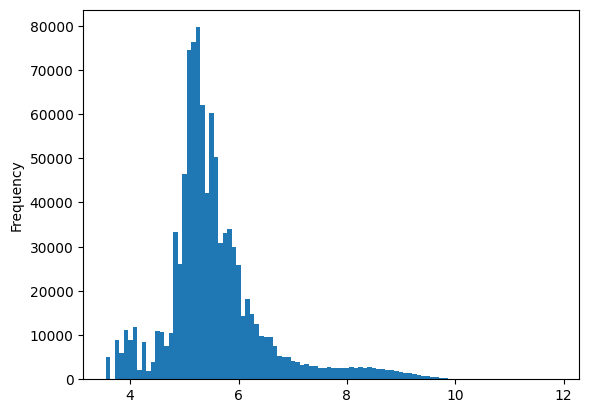

In [44]:
df_train.head(1000000)["normalized_count"].plot.hist(bins=100)

In [45]:
cell_types = ad_train.obs.cell_type.unique()
perturbations = ad_train.obs.sm_name.unique()

In [46]:
ad_train[(ad_train.obs.cell_type==cell_types[1]) & (ad_train.obs.sm_name==perturbations[1]), :].shape

(54, 18211)

In [47]:
data = np.nan * np.empty((len(perturbations), len(cell_types)))
df_stats = pd.DataFrame(data, index=perturbations, columns=cell_types)

In [48]:
# fill out table with numbers of samples per condition and cell type
for idx in perturbations:
  for col in cell_types:
    df_stats.loc[idx, col] = ad_train[(ad_train.obs.cell_type==col) & (ad_train.obs.sm_name==idx), :].shape[0]

In [49]:
df_stats

,T cells CD4+,T regulatory cells,NK cells,T cells CD8+,B cells,Myeloid cells
MLN 2238,697.0,1.0,4.0,392.0,2.0,5.0
BMS-265246,895.0,54.0,430.0,77.0,0.0,0.0
Resminostat,933.0,12.0,320.0,0.0,0.0,0.0
FK 866,532.0,46.0,260.0,62.0,0.0,0.0
Nilotinib,529.0,28.0,287.0,84.0,0.0,0.0
...,...,...,...,...,...,...
Crizotinib,506.0,37.0,305.0,87.0,215.0,117.0
BMS-387032,143.0,68.0,195.0,10.0,0.0,0.0
UNII-BXU45ZH6LI,257.0,16.0,28.0,6.0,0.0,0.0
Alvocidib,8.0,33.0,6.0,0.0,3.0,1.0


In [50]:
sel_cells = ["T cells CD4+", "T regulatory cells",	"NK cells",	"T cells CD8+"]

In [51]:
df_stats[sel_cells].sum(axis=1).sort_values(ascending=False)

Dimethyl Sulfoxide    18668.0
HMN-214                1514.0
Methotrexate           1482.0
Canertinib             1476.0
BMS-265246             1456.0
                       ...   
ABT737                  655.0
BMS-387032              416.0
UNII-BXU45ZH6LI         307.0
CGP 60474                89.0
Alvocidib                47.0
Length: 145, dtype: float64

In [52]:
# Select perturbations with largest number of samples
sel_perturb = df_stats[sel_cells].sum(axis=1).sort_values(ascending=False).index[:11]

In [53]:
# Number of samples per drug/cell_type
df_stats.loc[sel_perturb, sel_cells]

,T cells CD4+,T regulatory cells,NK cells,T cells CD8+
Dimethyl Sulfoxide,10778.0,812.0,5782.0,1296.0
HMN-214,920.0,61.0,457.0,76.0
Methotrexate,863.0,73.0,471.0,75.0
Canertinib,918.0,69.0,413.0,76.0
BMS-265246,895.0,54.0,430.0,77.0
Lapatinib,806.0,71.0,422.0,93.0
Ganetespib (STA-9090),544.0,4.0,779.0,12.0
Topotecan,765.0,74.0,414.0,79.0
Phenylbutazone,779.0,68.0,402.0,78.0
LDN 193189,813.0,55.0,385.0,74.0


In [54]:
ad_train_sel = ad_train[ad_train.obs.sm_name.isin(sel_perturb) & ad_train.obs.cell_type.isin(sel_cells)]

In [55]:
ad_train_sel.write(f"{DATA}/ad_train.top_drugs.h5ad", compression="gzip")

# Test (TMP)

In [ ]:
from anndata.experimental.pytorch import AnnLoader

In [ ]:
# Load the Anndata object
# adata = sc.read('data.h5ad')
# adata = ad.read('ad_train.sel.h5ad', backed='r')
# adata.file.close()


ad_train1 = ad.read_h5ad('ad_train.sel.h5ad')

In [ ]:
# Create a dataloader with a batch size of 128 and shuffle the data
dataloader = AnnLoader(ad_train1, batch_size=32, shuffle=True)

In [ ]:
for batch in tq.tqdm(dataloader):
    # Get the input data and labels
    batch = batch.X


100%|██████████| 393/393 [00:00<00:00, 523.35it/s]


In [ ]:
batch.shape

torch.Size([27, 18211])